# Spectral denoising the entire training-test set

We know that with denoising we should avoid denoising the entire time series as this leads to information leakage. So we take the approach of denoising only the training set. But we found literature that states one **should** denoise both the training and test set. So lets investigate what the impact of doing this is:

In [1]:
# import bespoke modules
from one_dimensional_time_series_forecasting import time_series_prediction, hit_rate, invert_first_difference,invert_first_difference_2,invert_scaling, invert_first_difference_with_log_2, invert_scaling,inverted_conclusion
from walkforward_validation import walk_forward_val, series_to_supervised
from spectral_denoising import automatic_fourier_denoising, automatic_fourier_denoising_wf, automatic_wavelet_denoising, automatic_wavelet_denoising_wf

# model evalution metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error

# data preprocessing
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler

# interactive figures
%matplotlib widget 

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from tabulate import tabulate

2022-06-29 09:41:16.350260: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-29 09:41:16.350304: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


To do:
- need to ensure that the inversation of forecasting results is done correctly. 

Result:
- the above was mostly correct, the mistake was that inverted_conclusion was computing evaluation metrics against the original, non-denoised signal, rather than the denoised signal.

# 1. Fourier denoising the entire time series

Trial 20 Complete [00h 01m 41s]
val_loss: 0.00033170777605846525

Best val_loss So Far: 0.00019954873132519425
Total elapsed time: 00h 26m 07s
INFO:tensorflow:Oracle triggered exit
Best LSTM hyperparamteres: <keras_tuner.engine.hyperparameters.HyperParameters object at 0x7f79fc1fb0a0>
Epoch 1/2000
24/24 [==============================] - 4s 27ms/step - loss: 0.0644
Epoch 2/2000
24/24 [==============================] - 1s 28ms/step - loss: 0.0148
Epoch 3/2000
24/24 [==============================] - 1s 27ms/step - loss: 0.0020
Epoch 4/2000
24/24 [==============================] - 1s 31ms/step - loss: 0.0011
Epoch 5/2000
24/24 [==============================] - 1s 28ms/step - loss: 9.9262e-04
Epoch 6/2000
24/24 [==============================] - 1s 27ms/step - loss: 9.1225e-04
Epoch 7/2000
24/24 [==============================] - 1s 28ms/step - loss: 8.4270e-04
Epoch 8/2000
24/24 [==============================] - 1s 29ms/step - loss: 8.5754e-04
Epoch 9/2000
24/24 [======================

/tmp/ipykernel_11567/1126601141.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inverted_results['Linear'].iloc[-split:] = inverted_predictions_linear.flatten()#['invert_pred_value'].astype(float)
/tmp/ipykernel_11567/1126601141.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inverted_results['SVM'].iloc[-split:] = inverted_predictions_svm.flatten()#['invert_pred_value'].astype(float)
/tmp/ipykernel_11567/1126601141.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

Movement prediction accuracy: 97.2 %
Confusion matrix:
[[277   8]
 [  6 209]]
Movement prediction accuracy: 74.6 %
Confusion matrix:
[[221  64]
 [ 63 152]]
Movement prediction accuracy: 90.6 %
Confusion matrix:
[[261  24]
 [ 23 192]]
Movement prediction accuracy: 96.6 %
Confusion matrix:
[[275  10]
 [  7 208]]
+----+-------------------+-------------+-------------+-------------+-------+
|    | model             |        RMSE |         MAE |        MAPE |    DA |
|----+-------------------+-------------+-------------+-------------+-------|
|  0 | Linear Regression | 0.000932156 | 0.000263854 | 0.000230083 | 0.972 |
|  1 | SVM               | 0.00938345  | 0.00731248  | 0.00633756  | 0.746 |
|  2 | MLP               | 0.00498621  | 0.00454581  | 0.0039175   | 0.906 |
|  3 | LSTM              | 0.00161004  | 0.00137462  | 0.00117294  | 0.966 |
+----+-------------------+-------------+-------------+-------------+-------+


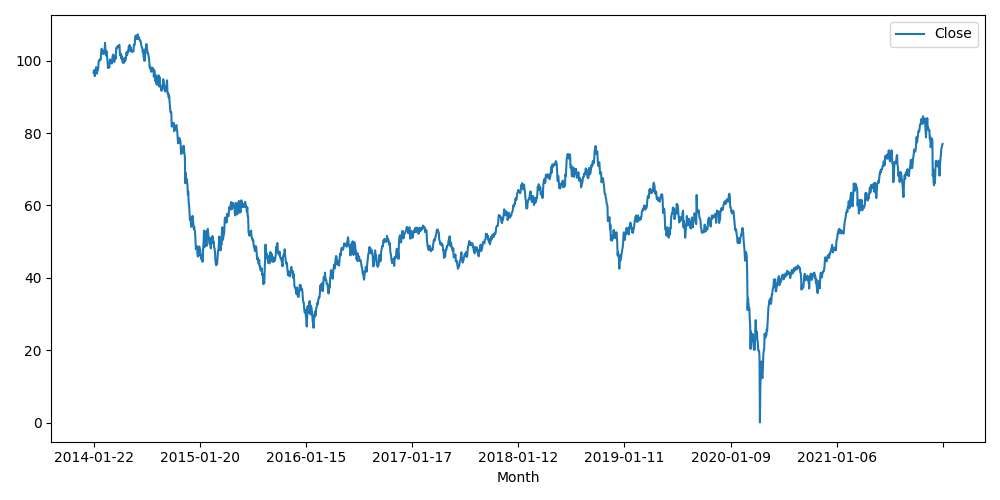

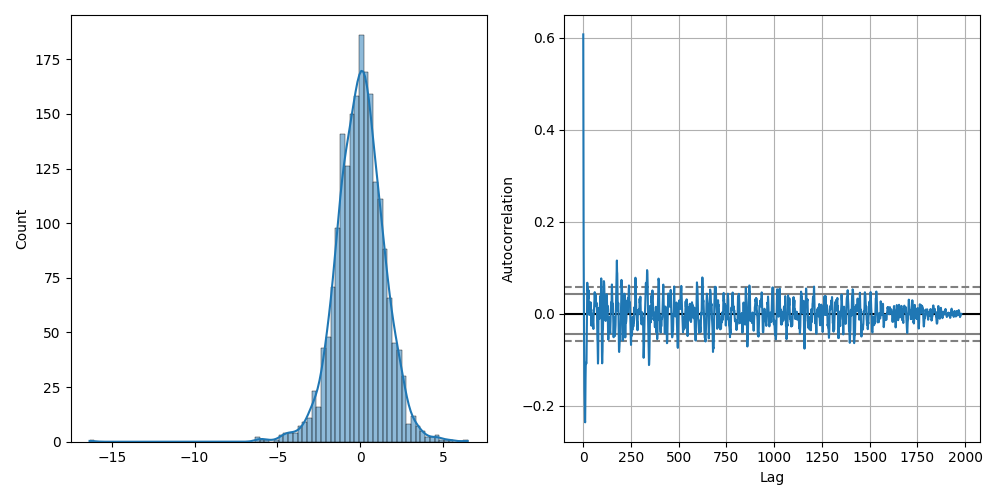

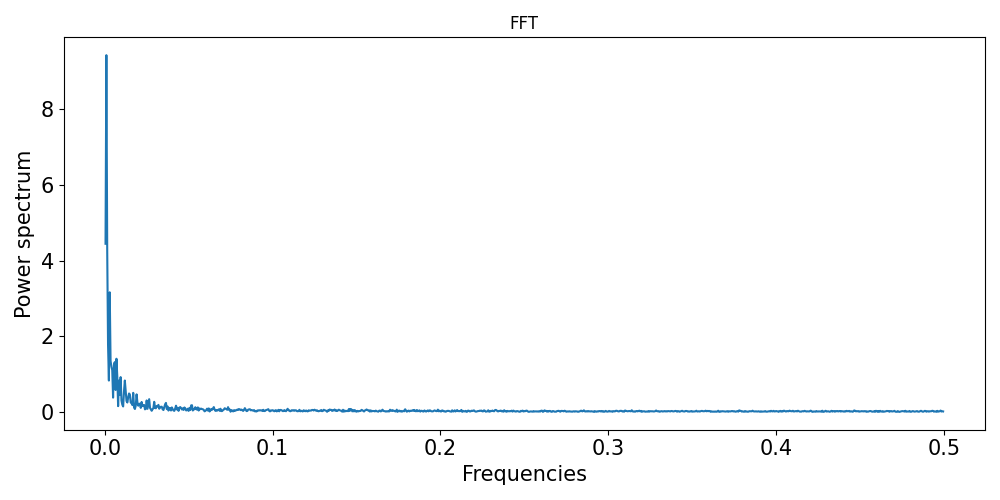

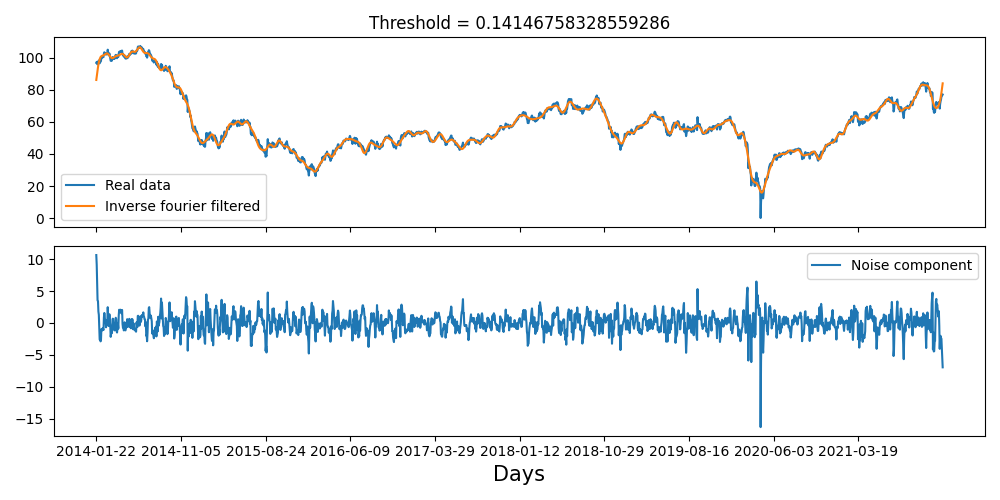

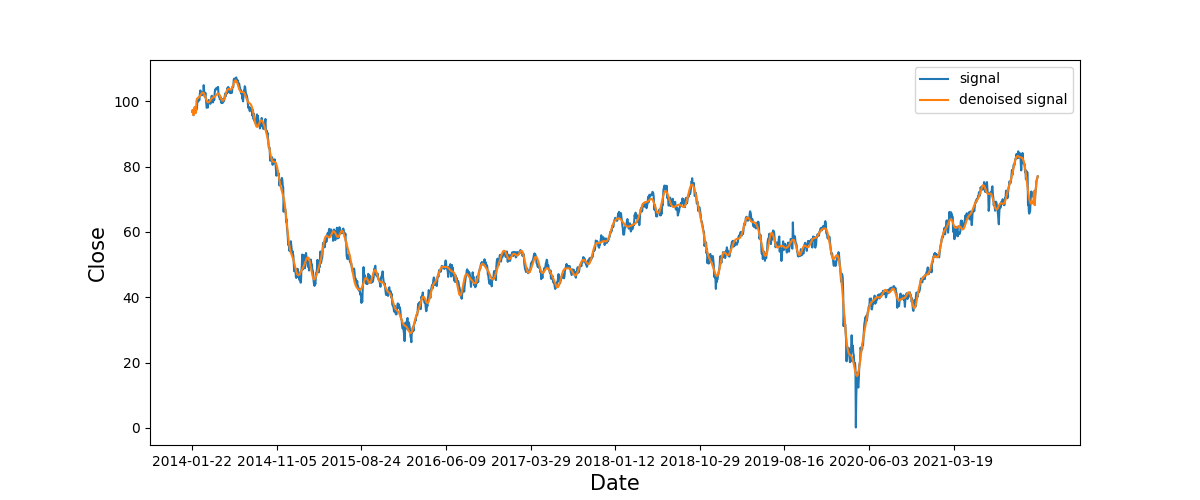

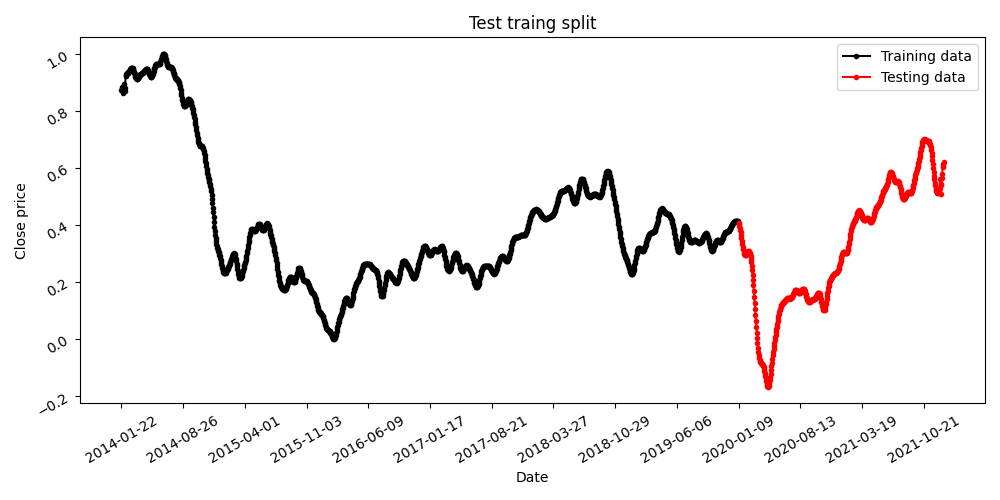

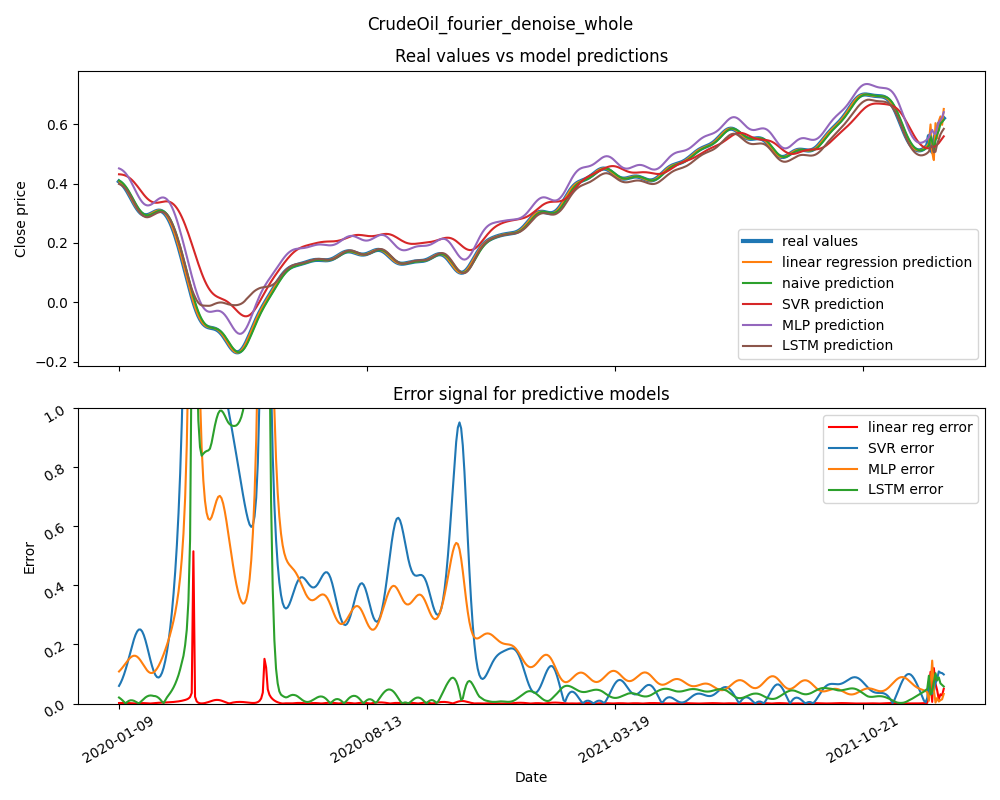

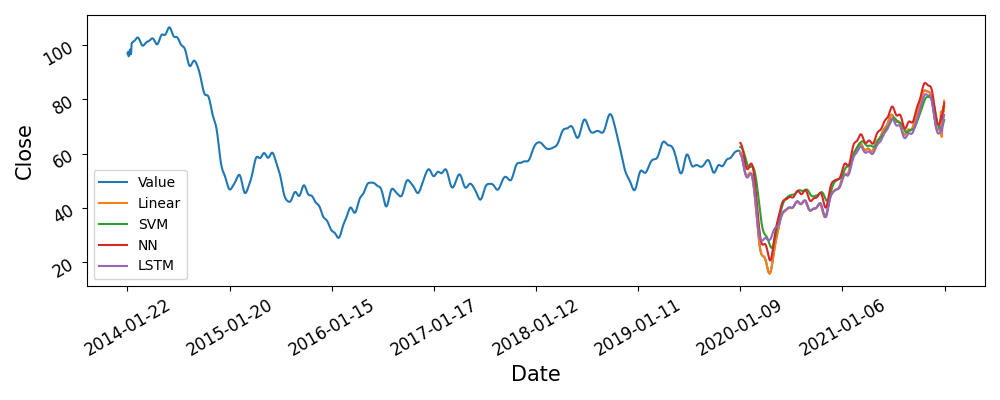

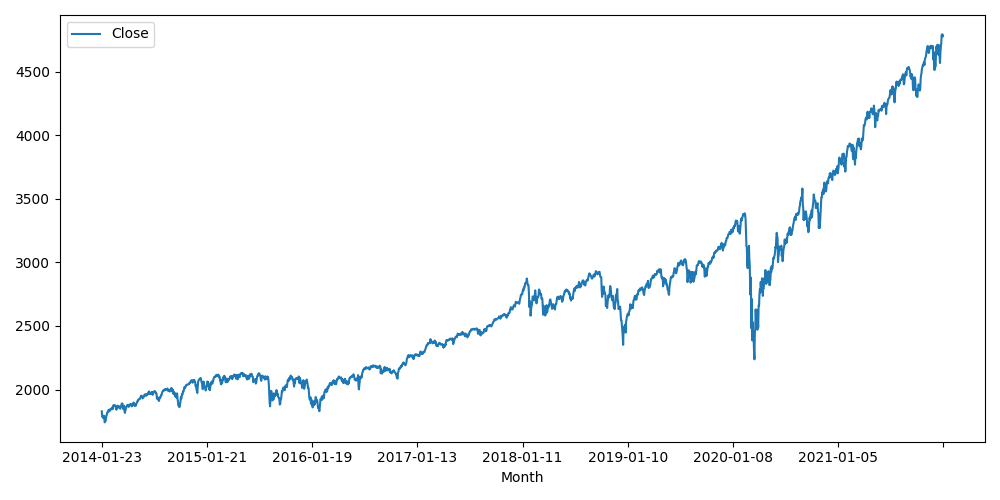

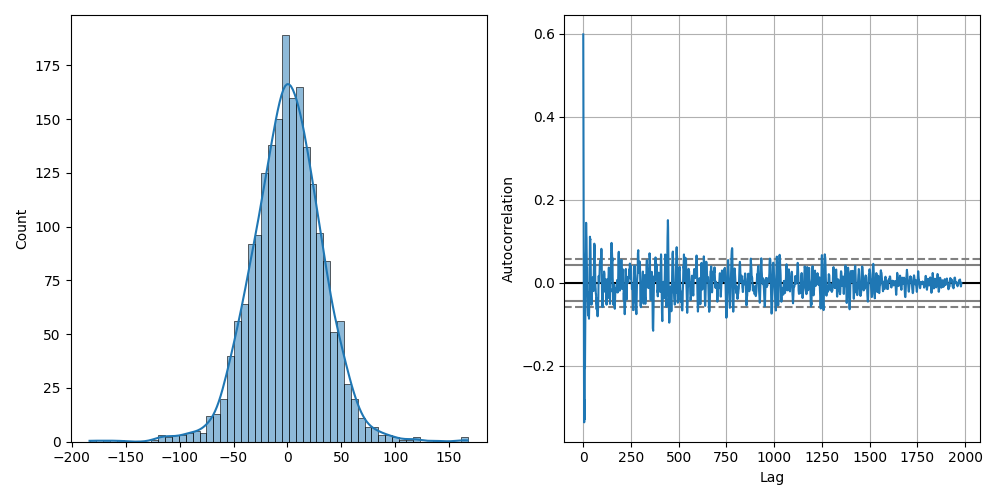

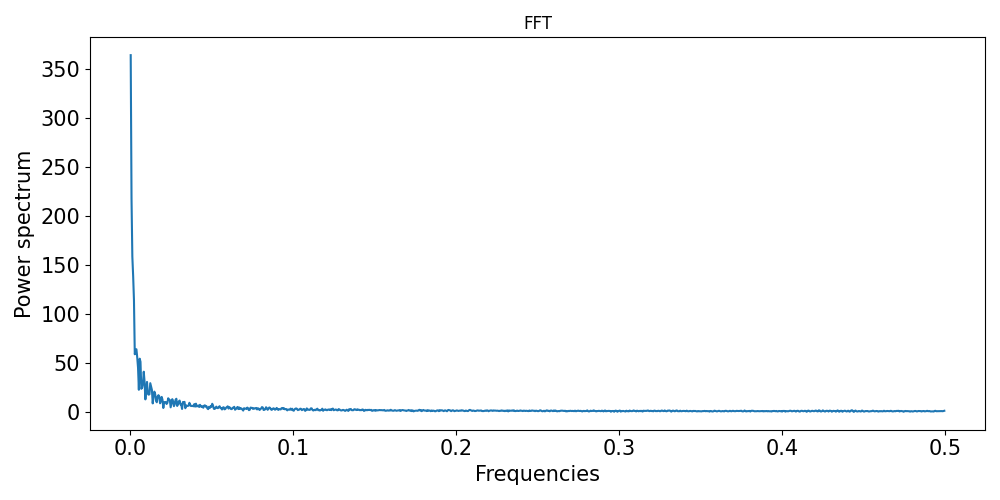

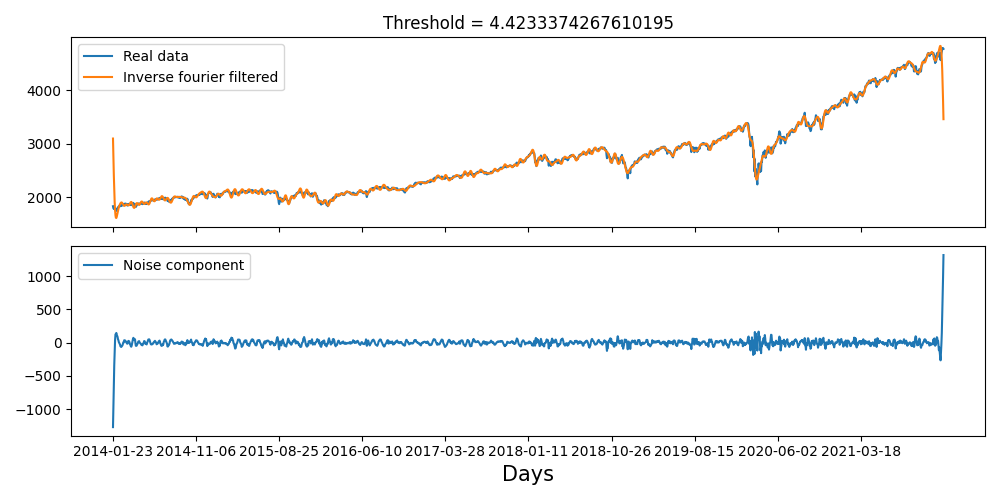

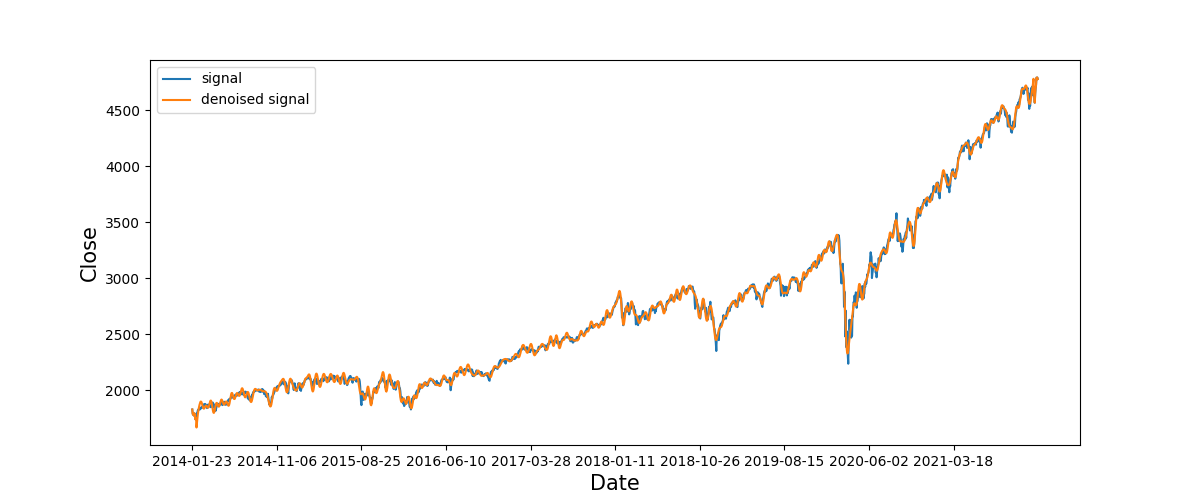

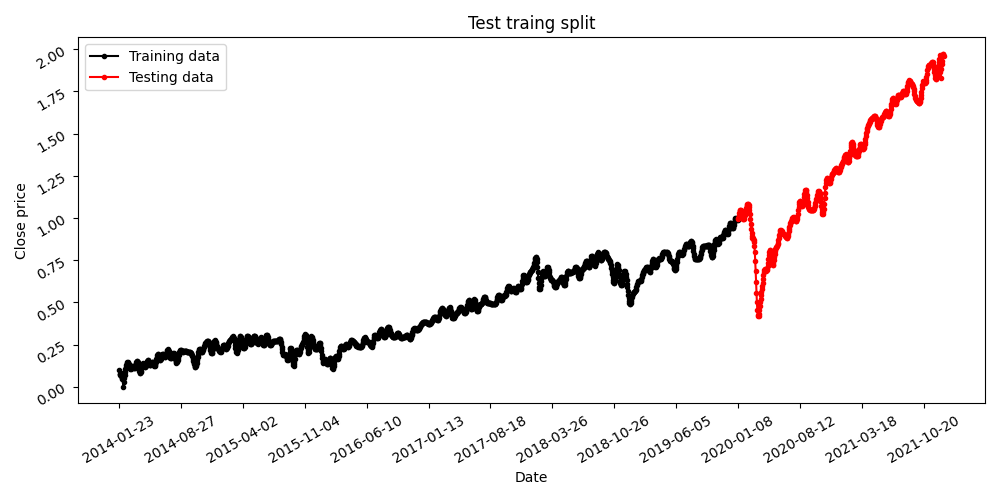

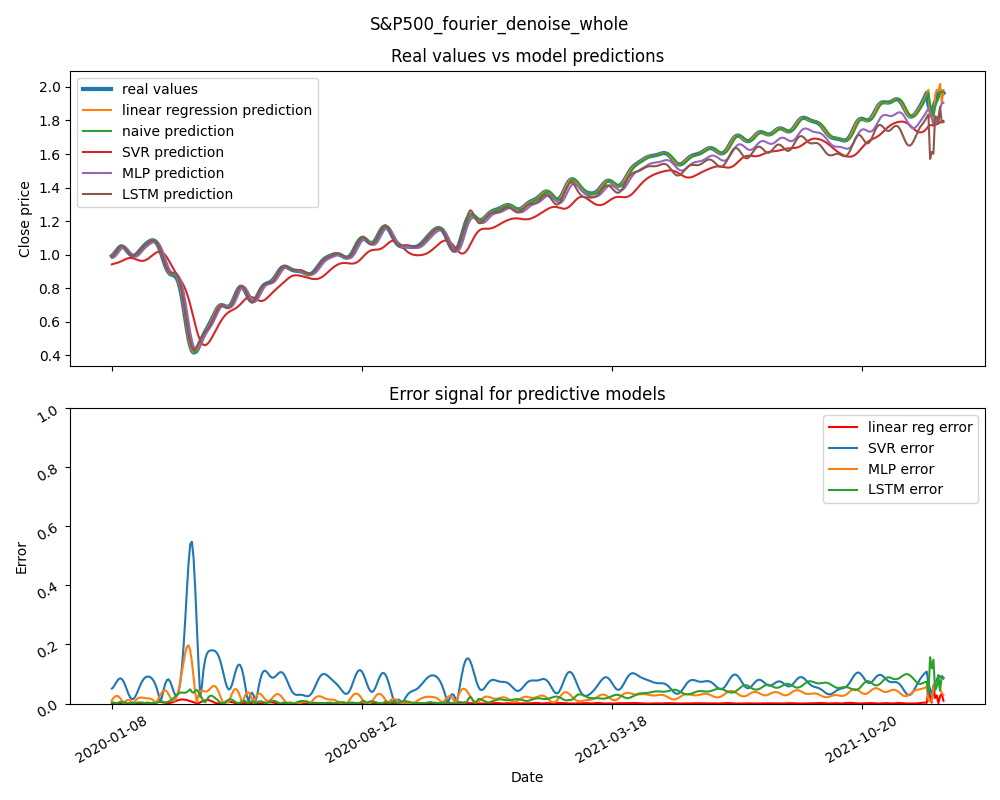

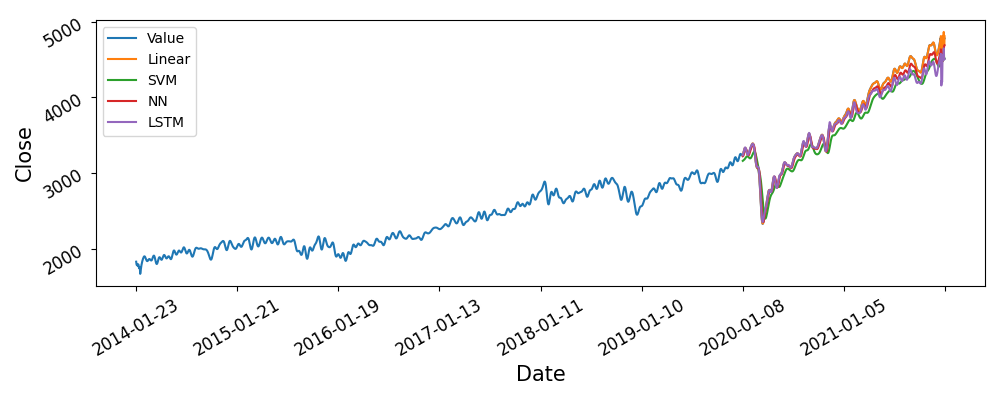

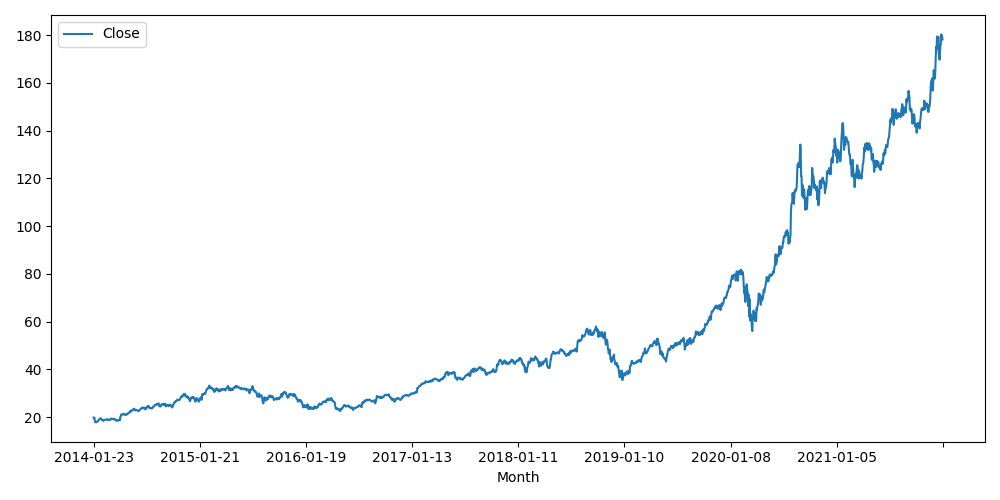

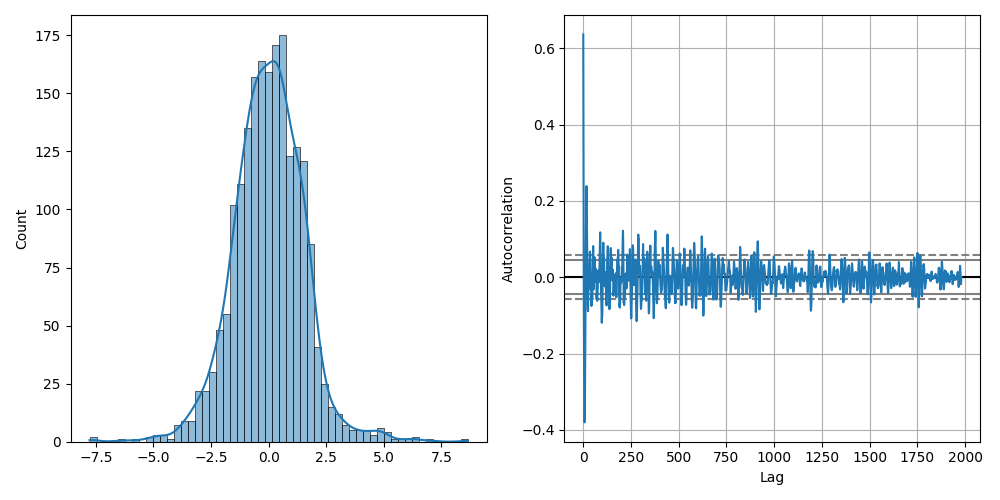

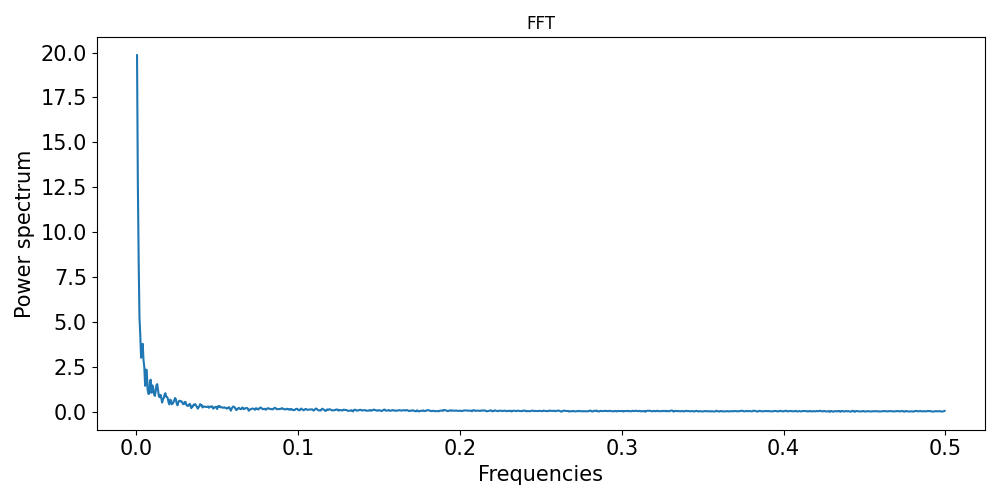

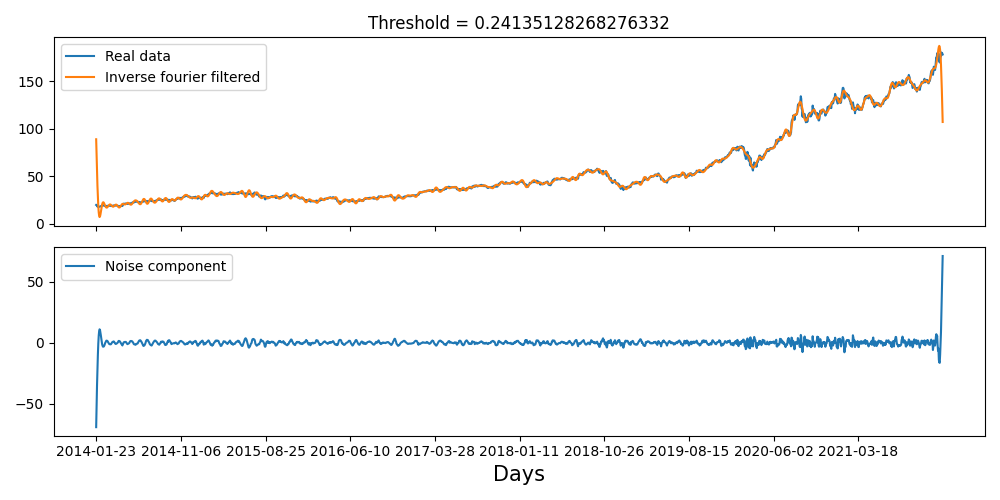

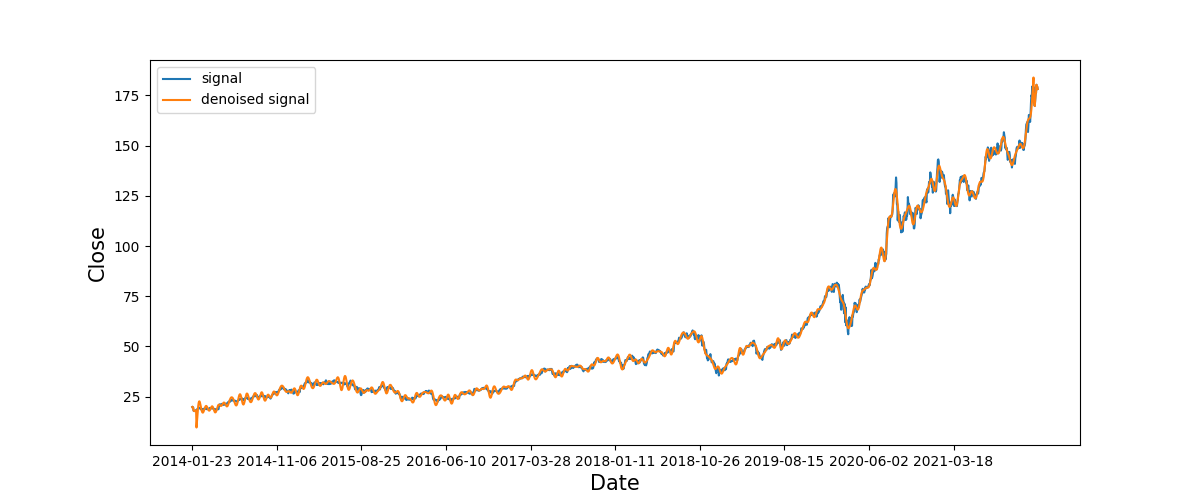

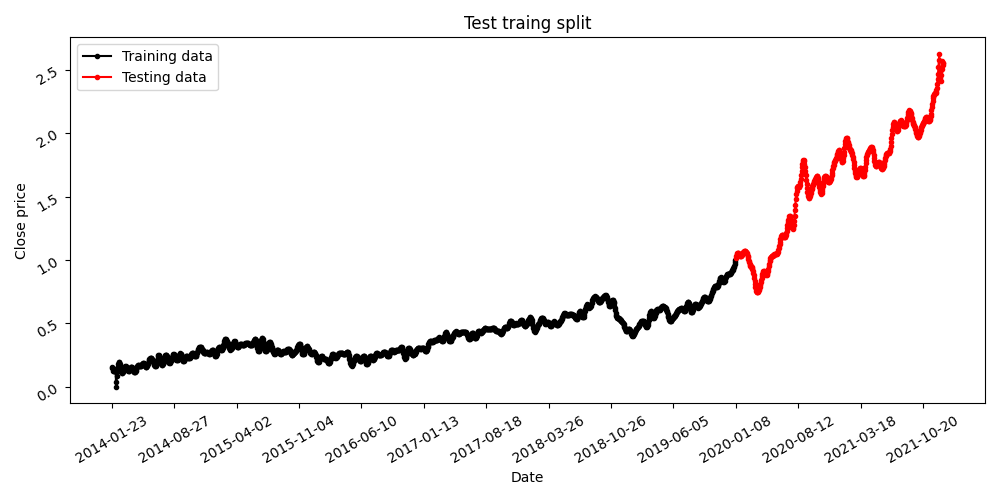

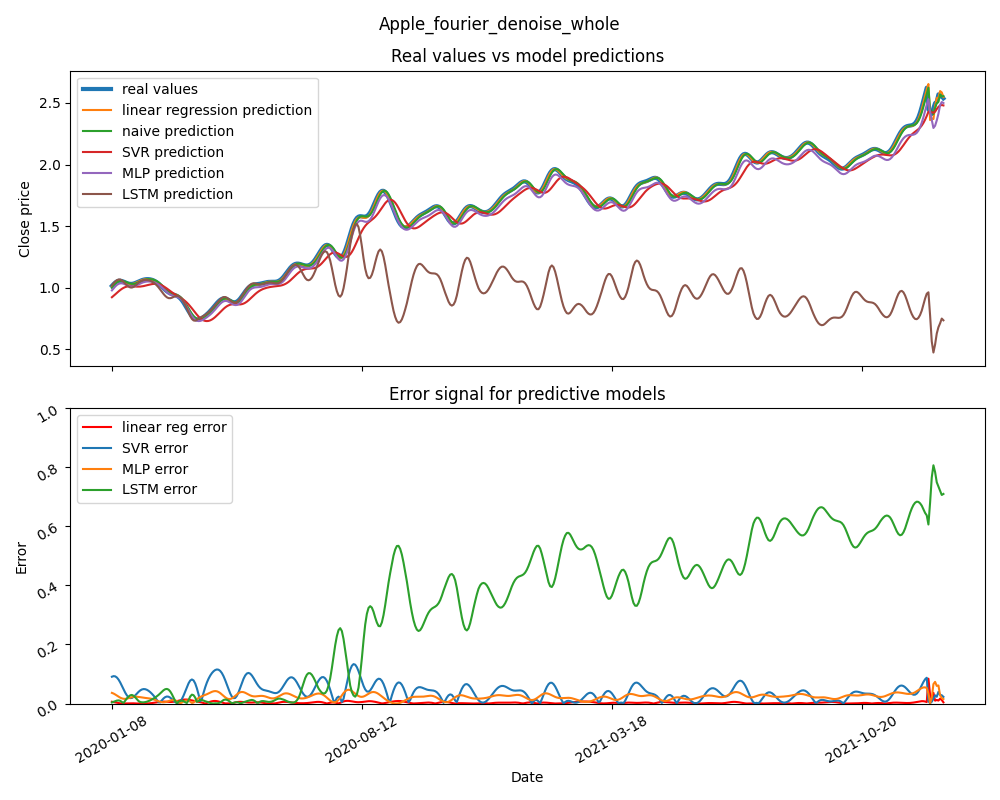

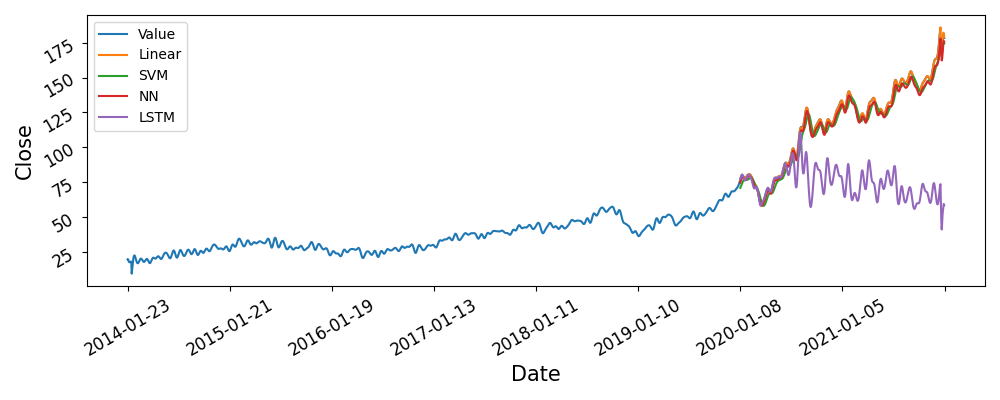

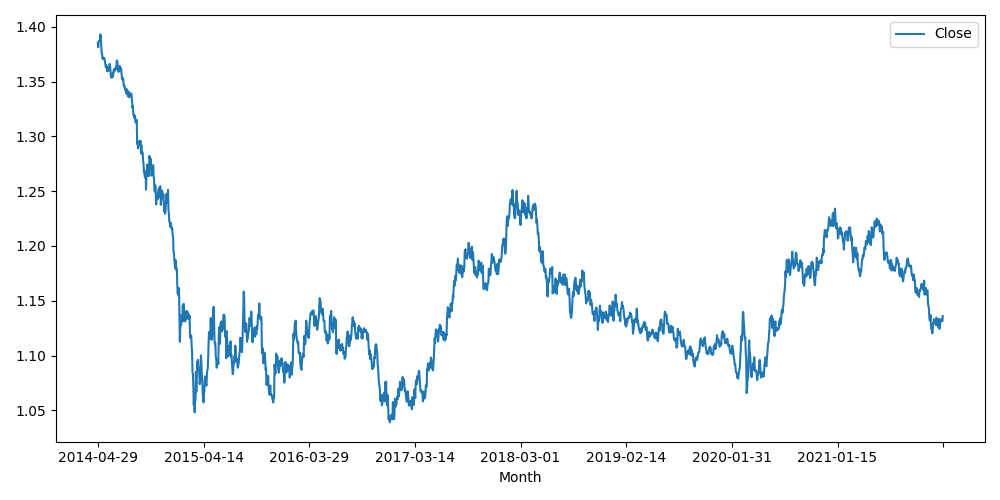

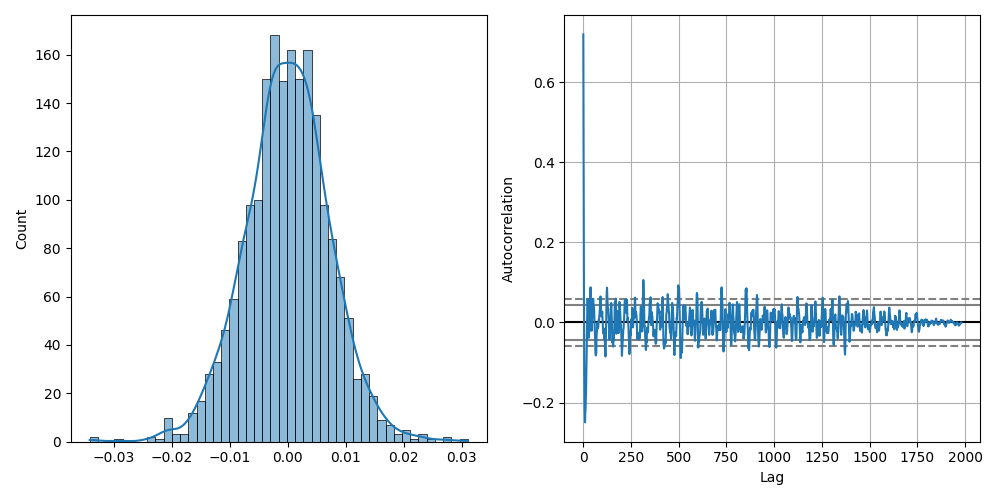

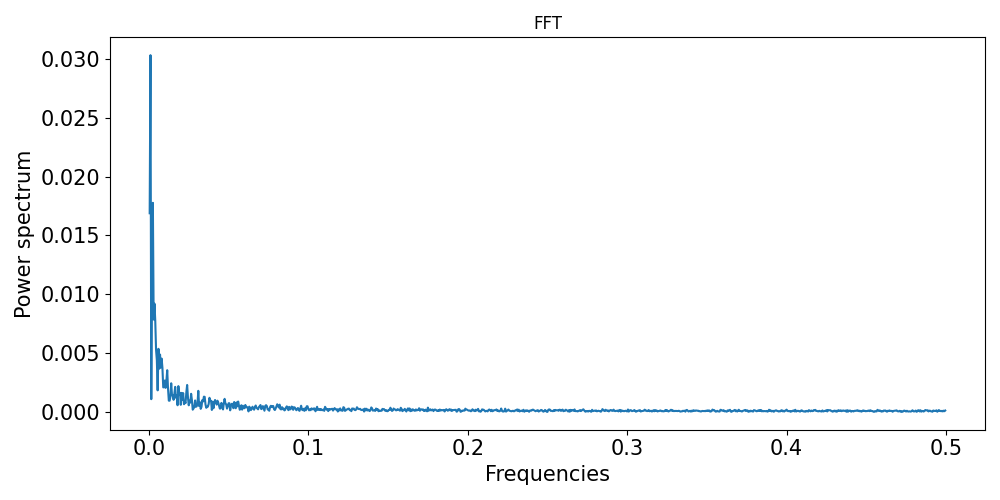

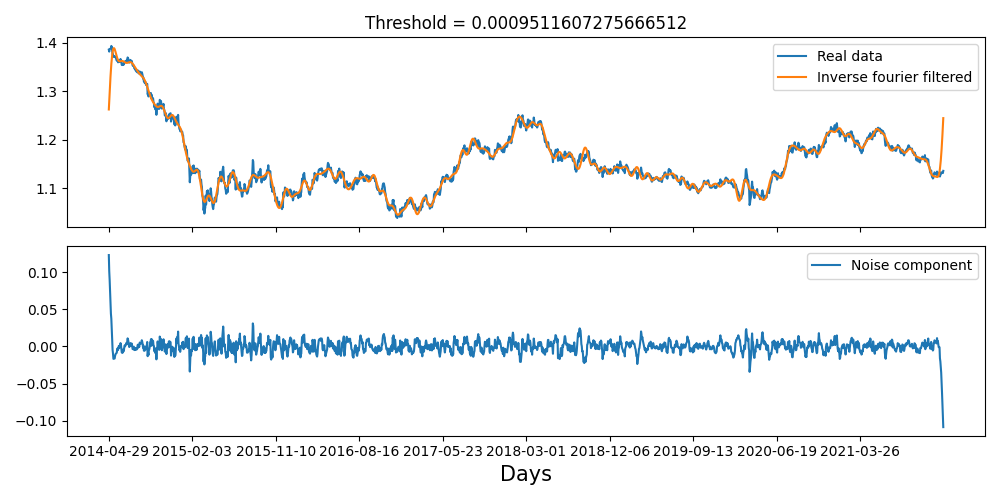

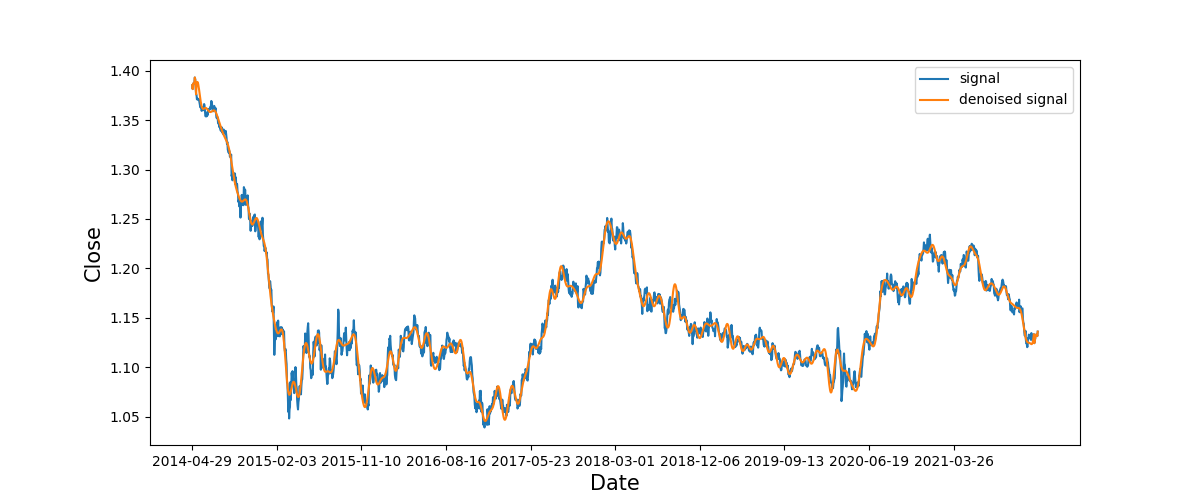

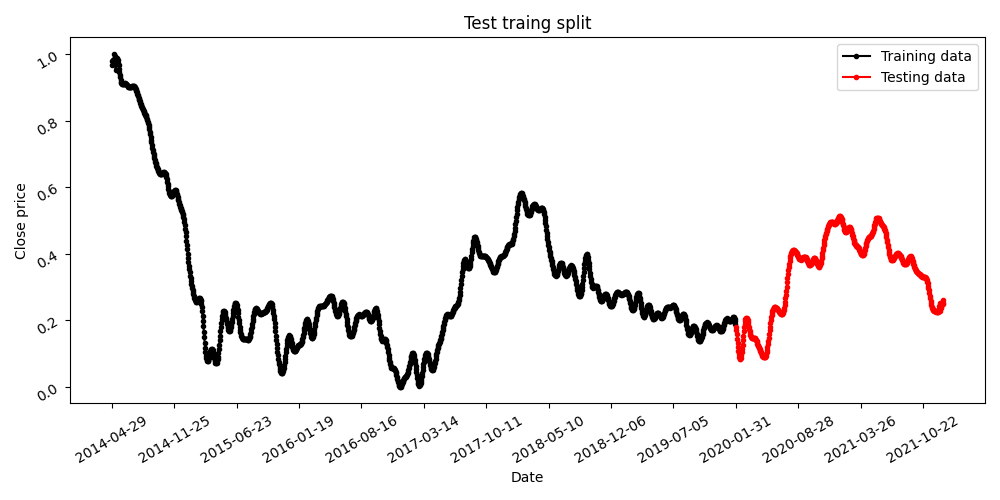

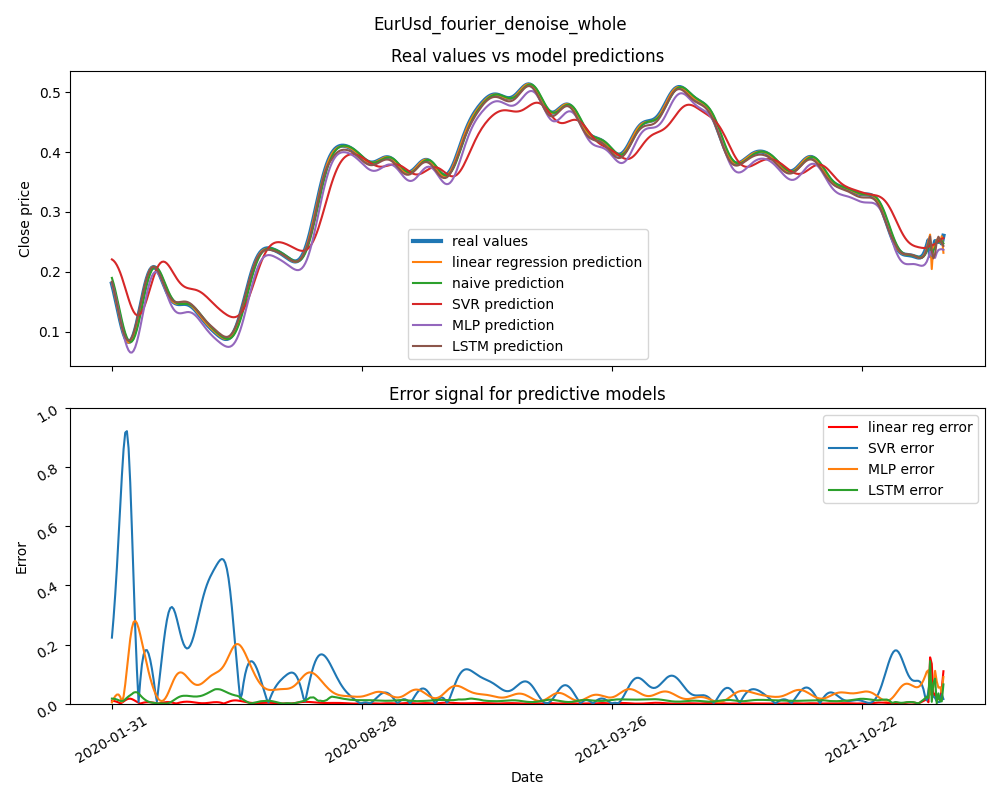

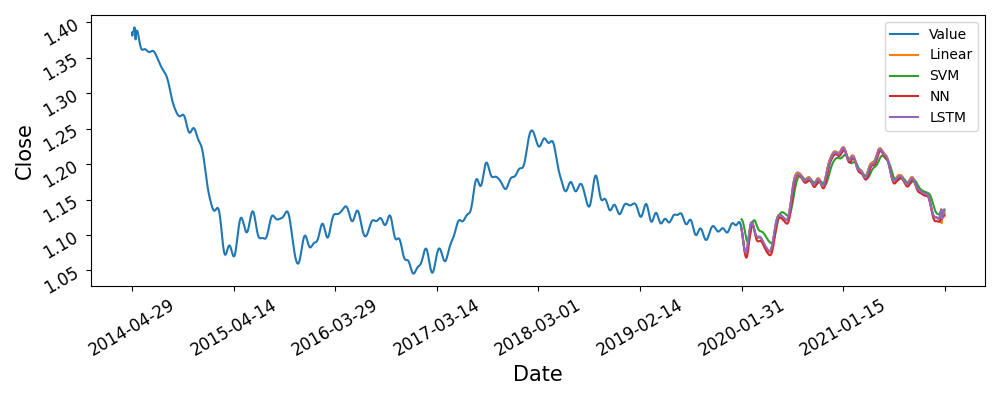

In [3]:
financial_assets = ['CrudeOil','S&P500','Apple','EurUsd']# ,'EurUsd'] # AirPassengers',
feat_engineering = 'fourier_denoise_whole'
column_to_predict = 'Close' #'#Passengers' 

for financial_asset in financial_assets:
    ###################################################################################################
    # import some data
    ###################################################################################################

    df = pd.read_csv(f'./test_data/{financial_asset}_yfinance.csv') # sp_500 = GSPC.csv, # airplaine = AirPassengers.csv
    df = df.iloc[-2000:,:].reset_index(drop=True) # only look at last 2000 days
    # df['Date'] = df['Month']
    df.plot(x='Date',y=f'{column_to_predict}',figsize=(10,5),legend=True,xlabel='Month',subplots=True)
    plt.tight_layout()
    display(df)

    # some forecasting parameters
    window_length = 10
    split = 500 # 44 for AirPlane

    ###################################################################################################
    # feature engineering sigal to remove noise from the entire signal
    ###################################################################################################

    # fft to denoise WHOLE signal
    signal = np.array(df[f'{column_to_predict}'][-2000:]) 
    dates = df['Date'].iloc[-2000:]
    denoised_signal = automatic_fourier_denoising(signal,
                                                  dates,
                                                  verbose=True)

    plt.figure(figsize=(12,5))
    plt.plot(dates,signal,label='signal')
    plt.plot(dates,denoised_signal,label='denoised signal')
    plt.ylabel('Close',fontsize=15)
    plt.xlabel('Date',fontsize=15)
    plt.xticks([dates.iloc[x] for x in range(0,2000,200)])
    plt.tick_params(labelsize=10)
    plt.legend()
    plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_denoise_whole.png',facecolor='w')


    ###################################################################################################
    # single out of sample validation results
    ###################################################################################################

    # input data - denosing whole signal
    scaler = MinMaxScaler()
    scaled_training_data = scaler.fit_transform(denoised_signal[:-split].reshape(-1, 1)).flatten()
    scaled_test_data = scaler.transform(denoised_signal[-split:].reshape(-1, 1)).flatten()
    scaled_input_data = np.append(scaled_training_data,scaled_test_data)    

    # initialize class object
    blah = time_series_prediction(financial_asset,feat_engineering,df['Date'],scaled_input_data,window_length,1)#time_series_prediction(sp_500['Date'][-4000:],sp_500['Volume'][-4000:]/1e9,5,1) # pass: ime series dates, univariate time series, lag window length, a number of steps ahead to predict
    blah.sliding_window_1(verbose=0) # time series to supervised ML problem
    blah.train_test_split(split=split) # testing and training dataset split
    blah.test_train_plot(ylabel='Close price')    # visualize training split

    # perform some prediction tasks
    blah.linear_regression()
    blah.support_vector_machine(model_tunning=True,C= 0.1, kernel= 'linear',epsilon=0.1)
    blah.neural_net_mlp(model_tunning=True,
                        activation= 'relu', 
                        hidden_layer_sizes= (100, 100, 100), 
                        learning_rate= 'invscaling', 
                        learning_rate_init= 0.001,
                        solver='adam')
    blah.lstm(model_tunning=True,n_batch=64)
    blah.naive_model()

    # tabulate results nicely
    blah.collect_results()

    # visualize results
    blah.vis_results_time_series(ylabel='Close price',second_plot='error')

    # view final results
    blah.conclusion()

    ###################################################################################################
    # invert feature engineering (if possible)
    ###################################################################################################

    # invert scaling of predictions and test set
    inverted_predictions_linear, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.linear_reg_predictions)
    inverted_predictions_svm, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.svm_predictions)
    inverted_predictions_nn, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.neural_net_predictions)
    inverted_predictions_lstm, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.lstm_predictions)

    # collect inverted results

    df_inverted_results = pd.DataFrame(columns=['Date','Value','Linear','SVM','NN','LSTM'])
    df_inverted_results['Date'] = df['Date']
    df_inverted_results['Value'] = denoised_signal #df[f'{column_to_predict}']
    df_inverted_results['Linear'].iloc[-split:] = inverted_predictions_linear.flatten()#['invert_pred_value'].astype(float)
    df_inverted_results['SVM'].iloc[-split:] = inverted_predictions_svm.flatten()#['invert_pred_value'].astype(float)
    df_inverted_results['NN'].iloc[-split:] =  inverted_predictions_nn.flatten()#['invert_pred_value'].astype(float)
    df_inverted_results['LSTM'].iloc[-split:] = inverted_predictions_lstm.flatten()#['invert_pred_value'].astype(float)

    # plot invert results
    ax = df_inverted_results.plot(figsize=(10,4), x='Date', fontsize=15)
    ax.set_ylabel(ylabel=f'{column_to_predict}',fontsize=15)
    ax.set_xlabel(xlabel='Date',fontsize=15)
    ax.tick_params(rotation=30, labelsize=12)    
    plt.tight_layout()
    plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_inverted.png')

    # store results
    inverted_conclusion(dates=df['Date'].iloc[-split:],
                        original_values=denoised_signal[-split:], # when testing whole denoised signal, we must compare prediction against denoised, not orginal signal
                        linear_preds=inverted_predictions_linear, 
                        svm_pred=inverted_predictions_svm, 
                        nn_preds=inverted_predictions_nn, 
                        lstm_preds=inverted_predictions_lstm,
                        financial_asset=financial_asset,
                        feat_engineer=feat_engineering)

